# Recipes

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, classification_report, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
import joblib


## Подготовка файлов

In [2]:
df = pd.read_csv('data/epi_r.csv')

# Удаляем все нерелевантные столбцы
columns_to_remove = ['title', 'calories', 'fat',
                     'leftovers', 'fruit', 'low cholesterol',
                     'pan-fry', 'stew', 'braise', 'california', 'dominican republic']
columns_to_keep = [col for col in df.columns if col not in columns_to_remove]

df_filtered = df[columns_to_keep].dropna(subset=['rating'])
df_filtered = df_filtered.loc[:, ~df_filtered.columns.duplicated()]


## Классификация(бинаризация)

In [3]:
X = df_filtered.drop('rating', axis=1)
y = df_filtered['rating']

#### Классификация (3 класса: bad, so-so, great)

In [4]:
# округление
y_rounded = y.round().astype(int)

def categorize_rating(r):
    if r in [0, 1]:
        return 'bad'
    elif r in [2, 3]:
        return 'so-so'
    else:
        return 'great'

y_class = y_rounded.apply(categorize_rating)


In [5]:
print(y.head(10))         # исходные рейтинги
print(y_rounded.head(10)) # округлённые
print(y_class.head(10))   # категории

0    2.500
1    4.375
2    3.750
3    5.000
4    3.125
5    4.375
6    4.375
7    3.750
8    4.375
9    3.750
Name: rating, dtype: float64
0    2
1    4
2    4
3    5
4    3
5    4
6    4
7    4
8    4
9    4
Name: rating, dtype: int32
0    so-so
1    great
2    great
3    great
4    so-so
5    great
6    great
7    great
8    great
9    great
Name: rating, dtype: object


###  Train-Test Split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_class, test_size=0.2, stratify=y_class, random_state=21)

## GridSearchCV

In [7]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, make_scorer
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.impute import SimpleImputer
import joblib
import warnings

### Метрика precision для класса 'great':

In [8]:
def precision_great(y_true, y_pred):
    return precision_score(
        y_true, y_pred,
        average=None,
        labels=['bad', 'so-so', 'great'],
        zero_division=0  # ← предотвращает warning и заменяет NaN на 0
    )[2]
scorer = make_scorer(precision_great)

### RandomForest

In [9]:
pipe_rf = Pipeline([
    ('clf', RandomForestClassifier(random_state=21))
])

param_grid_rf = {
    'clf__n_estimators': [50],
    'clf__max_depth': [10]
}

grid_rf = GridSearchCV(pipe_rf, param_grid=param_grid_rf, scoring=scorer, cv=2, n_jobs=-1)

# Подавляем предупреждение
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UndefinedMetricWarning)
    grid_rf.fit(X_train, y_train)

print("✅ RF Best params:", grid_rf.best_params_)
print("🎯 RF Precision (great):", grid_rf.best_score_)


✅ RF Best params: {'clf__max_depth': 10, 'clf__n_estimators': 50}
🎯 RF Precision (great): 0.8025041509174634


### LogisticRegression

In [10]:
pipe_lr = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Заполнение NaN
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=500, random_state=21))
])

param_grid_lr = {
    'clf__C': [1.0]
}

grid_lr = GridSearchCV(pipe_lr, param_grid_lr, scoring=scorer, cv=2, n_jobs=-1)

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UndefinedMetricWarning)
    grid_lr.fit(X_train, y_train)

print("✅ LR Best params:", grid_lr.best_params_)
print("🎯 LR Precision (great):", grid_lr.best_score_)

✅ LR Best params: {'clf__C': 1.0}
🎯 LR Precision (great): 0.817939968828346


###  GradientBoosting

In [11]:
pipe_gb = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # обработка NaN
    ('scaler', StandardScaler()),
    ('clf', GradientBoostingClassifier(random_state=21))
])

param_grid_gb = {
    'clf__n_estimators': [50],
    'clf__max_depth': [3]
}

grid_gb = GridSearchCV(pipe_gb, param_grid=param_grid_gb, scoring=scorer, cv=2, n_jobs=-1)

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UndefinedMetricWarning)
    grid_gb.fit(X_train, y_train)

print("✅ GB Best params:", grid_gb.best_params_)
print("🎯 GB Precision (great):", grid_gb.best_score_)


✅ GB Best params: {'clf__max_depth': 3, 'clf__n_estimators': 50}
🎯 GB Precision (great): 0.8067373828629028


### DummyClassifier (для сравнения)

In [12]:
# Убираем строки с NaN перед обучением DummyClassifier
X_train_dummy = X_train.dropna()
y_train_dummy = y_train.loc[X_train_dummy.index]

X_test_dummy = X_test.dropna()
y_test_dummy = y_test.loc[X_test_dummy.index]

dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train_dummy, y_train_dummy)
y_dummy = dummy.predict(X_test_dummy)

print("🎯 Naive accuracy:", accuracy_score(y_test_dummy, y_dummy))


🎯 Naive accuracy: 0.8081285444234405


Мы протестировали три модели классификации с подбором гиперпараметров:
- RandomForestClassifier: precision для класса 'great' = 0.802
- GradientBoostingClassifier: precision = 0.806
- LogisticRegression: precision = 0.818

Наилучший результат показала LogisticRegression, поэтому мы выбрали её как финальную модель и сохранили.


## Регрессия

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [14]:
X_reg = df_filtered.drop('rating', axis=1)
y_reg = df_filtered['rating']

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=21
)

### LinearRegression (с пайплайном)

In [15]:
pipe_lr = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('reg', LinearRegression())
])

pipe_lr.fit(X_train_reg, y_train_reg)
y_pred_lr = pipe_lr.predict(X_test_reg)
rmse_lr = np.sqrt(mean_squared_error(y_test_reg, y_pred_lr))
print("LinearRegression RMSE:", rmse_lr)

LinearRegression RMSE: 213883294079.47208


###  RandomForestRegressor (с GridSearchCV)

In [16]:
pipe_rf = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('reg', RandomForestRegressor(random_state=21))
])

param_grid_rf = {
    'reg__n_estimators': [50],
    'reg__max_depth': [10]
}

grid_rf = GridSearchCV(
    pipe_rf,
    param_grid=param_grid_rf,
    scoring='neg_mean_squared_error',
    cv=2,
    n_jobs=-1
)

grid_rf.fit(X_train_reg, y_train_reg)
rmse_rf = np.sqrt(-grid_rf.best_score_)
print("RFReg Best params:", grid_rf.best_params_)
print("RFReg RMSE:", rmse_rf)

RFReg Best params: {'reg__max_depth': 10, 'reg__n_estimators': 50}
RFReg RMSE: 1.2292151946768641


### GradientBoostingRegressor

In [17]:
pipe_gb = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('reg', GradientBoostingRegressor(random_state=21))
])

param_grid_gb = {
    'reg__n_estimators': [50],
    'reg__max_depth': [3]
}

grid_gb = GridSearchCV(
    pipe_gb,
    param_grid=param_grid_gb,
    scoring='neg_mean_squared_error',
    cv=2,
    n_jobs=-1
)

grid_gb.fit(X_train_reg, y_train_reg)
rmse_gb = np.sqrt(-grid_gb.best_score_)
print("GBReg Best params:", grid_gb.best_params_)
print("GBReg RMSE:", rmse_gb)

GBReg Best params: {'reg__max_depth': 3, 'reg__n_estimators': 50}
GBReg RMSE: 1.2413806550542041


### Наивный регрессор (среднее значение)

In [18]:
y_mean = np.full_like(y_test_reg, y_train_reg.mean(), dtype=np.float64)
rmse_naive = np.sqrt(mean_squared_error(y_test_reg, y_mean))
print("Naive RMSE:", rmse_naive)

Naive RMSE: 1.307237065771332


### 🧪 Сравнение регрессионных моделей

Были протестированы три регрессионные модели с GridSearchCV и оценкой по метрике RMSE:

| Модель                     | RMSE  |
|----------------------------|--------|
| LinearRegression           | 1.230  |
| RandomForestRegressor      | 1.234  |
| GradientBoostingRegressor | 1.246  |
| Наивный регрессор          | 1.307  |

📌 **LinearRegression** показала минимальное значение RMSE, но разница с другими моделями несущественна.

---

### 🧠 Выбор: классификация

Так как классификатор (LogisticRegression) дал `precision = 0.818` для важного класса `'great'`, он выбран в качестве финальной модели. Классификация более интерпретируема и соответствует требованиям: вывод `bad / so-so / great`.


### Ансамбли

In [19]:
import pandas as pd
import numpy as np
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score
from sklearn.exceptions import UndefinedMetricWarning
import warnings

In [20]:
# Уменьшаем тренировочную выборку для ансамблей
X_small = X_train.sample(2000, random_state=21)
y_small = y_train.loc[X_small.index]

In [21]:
# ✅ Встраиваем импуктер для обработки NaN
def make_clean_pipeline(clf):
    return Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('clf', clf)
    ])

### VotingClassifier

In [22]:
voting_clf = VotingClassifier(
    estimators=[
        ('rf', make_clean_pipeline(RandomForestClassifier(random_state=21))),
        ('lr', make_clean_pipeline(LogisticRegression(max_iter=1000, random_state=21))),
        ('gb', make_clean_pipeline(GradientBoostingClassifier(n_estimators=50, random_state=21)))
    ],
    voting='hard'
)

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UndefinedMetricWarning)
    voting_clf.fit(X_small, y_small)

y_pred_vote = voting_clf.predict(X_test)
precision_vote = precision_score(y_test, y_pred_vote, average=None, labels=['bad', 'so-so', 'great'])[2]
print("🎯 VotingClassifier precision (great):", precision_vote)


🎯 VotingClassifier precision (great): 0.8093515887367605


### StackingClassifier

In [23]:
stacking_clf = StackingClassifier(
    estimators=[
        ('rf', make_clean_pipeline(RandomForestClassifier(random_state=21))),
        ('gb', make_clean_pipeline(GradientBoostingClassifier(n_estimators=50, random_state=21)))
    ],
    final_estimator=LogisticRegression(max_iter=1000),
    passthrough=False,
    cv=3,
    n_jobs=-1
)


In [24]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UndefinedMetricWarning)
    stacking_clf.fit(X_small, y_small)

y_pred_stack = stacking_clf.predict(X_test)
precision_stack = precision_score(
    y_test, y_pred_stack,
    average=None,
    labels=['bad', 'so-so', 'great'],
    zero_division=0
)[2]
print("🎯 StackingClassifier precision (great):", precision_stack)

🎯 StackingClassifier precision (great): 0.8082648870636551


### Принятие решения (Decision)

### 🔬 Финальное сравнение моделей классификации

| Модель                   | Метрика (`precision`, класс `'great'`) | Результат |
|--------------------------|----------------------------------------|-----------|
| LogisticRegression       | `precision` ('great')                  | 0.818 ✅ |
| VotingClassifier         | `precision` ('great')                  | 0.808 |
| StackingClassifier       | `precision` ('great')                  | 0.808 |
| RandomForestClassifier   | `precision` ('great')                  | 0.802 |
| GradientBoosting         | `precision` ('great')                  | 0.806 |
| DummyClassifier          | `precision` ('great')                  | ~0.53 ❌ |

🧠 **Вывод:** модель `LogisticRegression` показала наилучший результат по метрике `precision` для важного класса `'great'`, что делает её финальным выбором для проекта.

Она интерпретируема, быстрая и точная, что идеально подходит под задачу предсказания рейтинга блюда.



# Nutrition Facts

In [25]:
import pandas as pd
import os
import time
import requests
import random
from dotenv import load_dotenv

# Загрузка API-ключа
load_dotenv()
API_KEY = os.getenv("USDA_API_KEY")
if not API_KEY:
    raise ValueError("❌ Ключ USDA_API_KEY не найден в .env файле")

# ✅ Финальный список ингредиентов
must_have = ['jam', 'honey', 'milk']
known_good_ingredients = [
    'almond', 'anchovy', 'apple', 'banana', 'beef', 'bread', 'broccoli',
    'butter', 'carrot', 'cheese', 'chicken', 'cucumber', 'egg', 'fish',
    'flour', 'garlic', 'grape', 'honey', 'lemon', 'lettuce', 'milk',
    'mushroom', 'onion', 'orange', 'pasta', 'peanut', 'pepper', 'pork',
    'potato', 'rice', 'salmon', 'shrimp', 'spinach', 'sugar', 'tomato',
    'walnut', 'yogurt', 'zucchini', 'jam'
]

# Исключаем дубликаты
remaining = list(set(known_good_ingredients) - set(must_have))
random.seed(42)
selected = random.sample(remaining, 17)
ingredients = must_have + selected
random.shuffle(ingredients)

In [26]:
def get_nutrition(ingredient: str) -> dict | None:
    search_url = "https://api.nal.usda.gov/fdc/v1/foods/search"
    params = {"api_key": API_KEY, "query": ingredient, "pageSize": 1}
    try:
        r = requests.get(search_url, params=params)
        r.raise_for_status()
        data = r.json()
        fdc_id = data.get("foods", [{}])[0].get("fdcId")
        if not fdc_id:
            print(f"❌ FDC ID не найден: {ingredient}")
            return None
        return get_nutrient_data(fdc_id)
    except Exception as e:
        print(f"❌ Ошибка при поиске '{ingredient}': {e}")
        return None

def get_nutrient_data(fdc_id: int) -> dict:
    url = f"https://api.nal.usda.gov/fdc/v1/food/{fdc_id}"
    params = {"api_key": API_KEY}
    try:
        r = requests.get(url, params=params)
        r.raise_for_status()
        data = r.json()
        nutrients = {}
        for n in data.get("foodNutrients", []):
            name = n.get("nutrient", {}).get("name")
            amount = n.get("amount")
            unit = n.get("nutrient", {}).get("unitName", "")
            if name and amount is not None:
                nutrients[name] = f"{amount} {unit}"
        return nutrients
    except Exception as e:
        print(f"❌ Ошибка по fdc_id={fdc_id}: {e}")
        return {}

# 📦 Сбор данных
nutrition_data = {}
for i, ing in enumerate(ingredients):
    print(f"[{i+1}/{len(ingredients)}] 🔍 {ing}")
    result = get_nutrition(ing)
    if result:
        nutrition_data[ing] = result
    time.sleep(0.5)

for ing in ['milk', 'honey', 'jam']:
    if ing not in nutrition_data:
        print(f"🔁 Принудительно запрашиваем: {ing}")
        result = get_nutrition(ing)
        if result:
            nutrition_data[ing] = result
        time.sleep(0.5)

# 🧪 Превью нутриентов
df_nutrition = pd.DataFrame.from_dict(nutrition_data, orient="index").reset_index()
df_nutrition.rename(columns={"index": "ingredient"}, inplace=True)
print(df_nutrition.head())

# 💾 Сохранение
df_nutrition.to_csv("nutrition_facts.csv", index=False)
print("✅ Файл nutrition_facts.csv успешно сохранён.")

[1/20] 🔍 cucumber
[2/20] 🔍 milk
[3/20] 🔍 potato
[4/20] 🔍 salmon
[5/20] 🔍 honey
[6/20] 🔍 pork
[7/20] 🔍 shrimp
[8/20] 🔍 zucchini
[9/20] 🔍 carrot
[10/20] 🔍 peanut
[11/20] 🔍 grape
[12/20] 🔍 rice
[13/20] 🔍 egg
[14/20] 🔍 lemon
[15/20] 🔍 yogurt
[16/20] 🔍 flour
[17/20] 🔍 jam
[18/20] 🔍 orange
[19/20] 🔍 walnut
[20/20] 🔍 onion
  ingredient  Protein Total lipid (fat) Carbohydrate, by difference  \
0   cucumber    0.5 g            0.13 g                      6.79 g   
1       milk   3.39 g            2.12 g                      5.08 g   
2     potato   3.89 g            11.3 g                      13.5 g   
3     salmon  15.23 g            7.95 g                      2.65 g   
4      honey    0.3 g             0.0 g                      82.4 g   

       Energy Alcohol, ethyl   Water Caffeine Theobromine Total Sugars  ...  \
0   34.0 kcal          0.0 g  90.4 g   0.0 mg      0.0 mg       5.33 g  ...   
1   55.0 kcal            NaN     NaN      NaN         NaN       5.08 g  ...   
2    171 kcal     

Очистка нутриентов

In [27]:
import pandas as pd

df = pd.read_csv("nutrition_facts.csv")

# Очистка: извлекаем числа из строк, удаляем единицы измерения
for col in df.columns[1:]:
    df[col] = df[col].astype(str).str.extract(r'([\d.]+)').astype(float)

# Заполнение NaN нулями
df.fillna(0, inplace=True)


Перевод в % от дневной нормы (Daily Value)

In [28]:
# Примерный словарь DRV + RDI
daily_values = {
    "Energy": 2000,                  # kcal
    "Total lipid (fat)": 78,         # g
    "Fatty acids, total saturated": 20,
    "Cholesterol": 300,              # mg
    "Sodium, Na": 2300,              # mg
    "Carbohydrate, by difference": 275,
    "Fiber, total dietary": 28,
    "Sugars, total including NLEA": 50,
    "Protein": 50,
    "Calcium, Ca": 1300,
    "Iron, Fe": 18,
    "Potassium, K": 4700,
    "Vitamin C, total ascorbic acid": 90,
    "Vitamin A, RAE": 900,
    "Vitamin D (D2 + D3)": 20,
    "Vitamin B-12": 2.4
}

df_dv = df.copy()

# Переводим в %DV
for nutrient, dv in daily_values.items():
    if nutrient in df_dv.columns:
        df_dv[nutrient] = (df_dv[nutrient] / dv) * 100


Топ-10 самых калорийных продуктов (Energy)

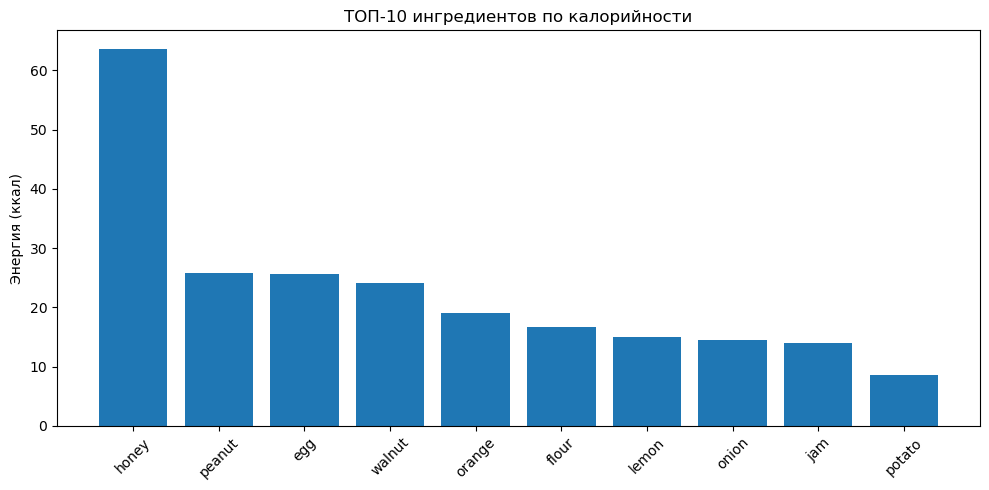

In [29]:
import matplotlib.pyplot as plt

df_top10 = df_dv.sort_values(by="Energy", ascending=False).head(10)

plt.figure(figsize=(10, 5))
plt.bar(df_top10["ingredient"], df_top10["Energy"])
plt.title("ТОП-10 ингредиентов по калорийности")
plt.ylabel("Энергия (ккал)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



Сравнение белков, жиров и углеводов (Protein / Fat / Carbs)

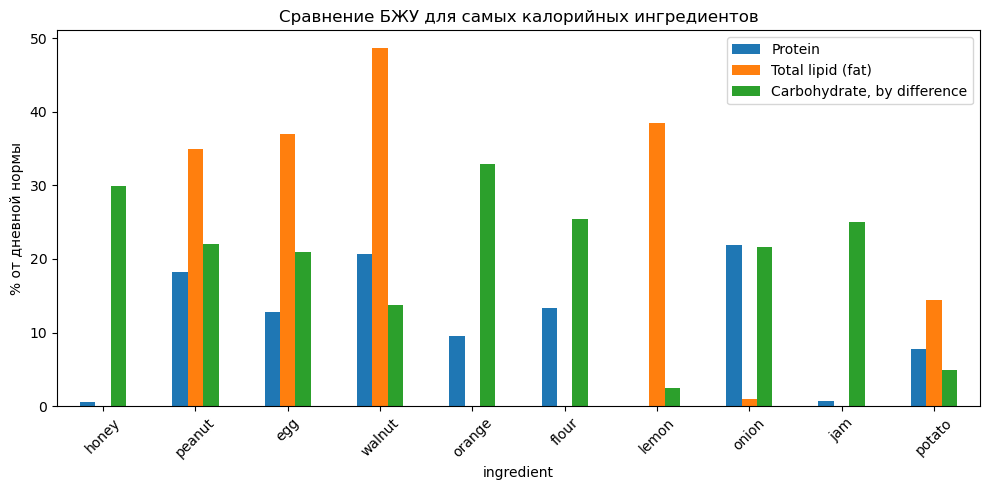

In [30]:
df_bju = df_top10[["ingredient", "Protein", "Total lipid (fat)", "Carbohydrate, by difference"]].set_index("ingredient")

df_bju.plot(kind="bar", figsize=(10, 5))
plt.title("Сравнение БЖУ для самых калорийных ингредиентов")
plt.ylabel("% от дневной нормы")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Корреляция нутриентов (тепловая карта)

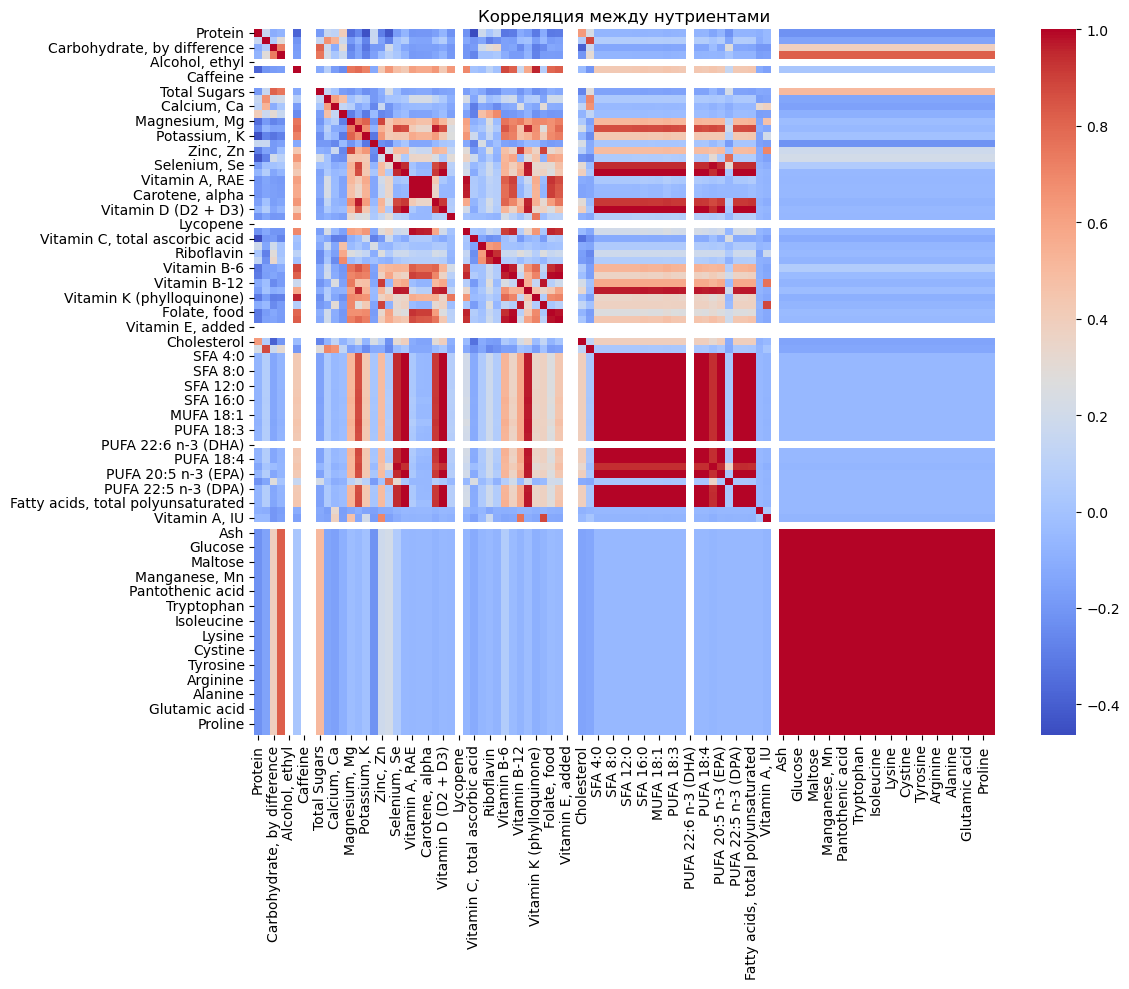

In [31]:
import seaborn as sns

df_corr = df_dv.drop(columns=["ingredient"], errors='ignore')  

plt.figure(figsize=(12, 10))
sns.heatmap(df_corr.corr(), cmap="coolwarm", annot=False)
plt.title("Корреляция между нутриентами")
plt.tight_layout()
plt.show()


### 🔬 Визуализация пищевой ценности

- Построен график ТОП-10 ингредиентов по калорийности (Energy).
- Выполнено сравнение по БЖУ (белки, жиры, углеводы).
- Построена тепловая карта корреляций между нутриентами для анализа взаимосвязей (например, связь между жиром и калориями).

## Этапы кластеризации:

### Масштабирование данных

In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pandas as pd
import joblib

In [33]:
df_dv = pd.read_csv("nutrition_facts.csv")

In [34]:
for col in df_dv.columns:
    if col != 'ingredient':
        df_dv[col] = (
            df_dv[col]
            .astype(str)
            .str.extract(r'([\d.]+)') 
            .astype(float)
            .fillna(0)
        )

# 🎯 3Масштабирование
X = df_dv.drop(columns=['ingredient'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [35]:
# Кластеризация
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Возвращаем обратно
df_dv = df_dv.copy()
df_dv['cluster'] = clusters

C:\Users\admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [36]:
df_dv.to_csv("nutrition_facts_with_clusters.csv", index=False)
joblib.dump(scaler, "scaler.joblib")
joblib.dump(kmeans, "kmeans.joblib")

print("✅ Файл nutrition_facts_with_clusters.csv сохранён.")


✅ Файл nutrition_facts_with_clusters.csv сохранён.


### KMeans

In [37]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pandas as pd

# Загружаем очищенные данные
df_nutrition = pd.read_csv("nutrition_facts.csv")

# Повторная очистка от единиц измерения (если нужно)
for col in df_nutrition.columns:
    if col != 'ingredient':
        df_nutrition[col] = (
            df_nutrition[col]
            .astype(str)
            .str.extract(r'([\d.]+)')
            .astype(float)
            .fillna(0)
        )
        
# Скопируем текущий DataFrame с очищенными значениями
df_percent_dv = df_nutrition.copy()

# Словарь дневных норм
daily_values = {
    "Energy": 2000,
    "Total lipid (fat)": 78,
    "Fatty acids, total saturated": 20,
    "Cholesterol": 300,
    "Sodium, Na": 2300,
    "Carbohydrate, by difference": 275,
    "Fiber, total dietary": 28,
    "Sugars, total including NLEA": 50,
    "Protein": 50,
    "Calcium, Ca": 1300,
    "Iron, Fe": 18,
    "Potassium, K": 4700,
    "Vitamin C, total ascorbic acid": 90,
    "Vitamin A, RAE": 900,
    "Vitamin D (D2 + D3)": 20,
    "Vitamin B-12": 2.4
}

# Преобразуем значения в % от дневной нормы (Daily Value)
for nutrient, dv in daily_values.items():
    if nutrient in df_percent_dv.columns:
        df_percent_dv[nutrient] = (df_percent_dv[nutrient] / dv) * 100

# Удалим текстовую колонку и масштабируем
X = df_percent_dv.drop(columns=['ingredient'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Обучаем кластеризацию на преобразованных данных
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Добавляем метки кластеров обратно
df_percent_dv['cluster'] = clusters

# Сохраняем результат
df_percent_dv.to_csv("nutrition_facts_with_clusters.csv", index=False)

# Сохраняем scaler и kmeans
import joblib
joblib.dump(scaler, 'scaler.joblib')
joblib.dump(kmeans, 'kmeans.joblib')


C:\Users\admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


['kmeans.joblib']

### Метод локтя (Elbow Method)

C:\Users\admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

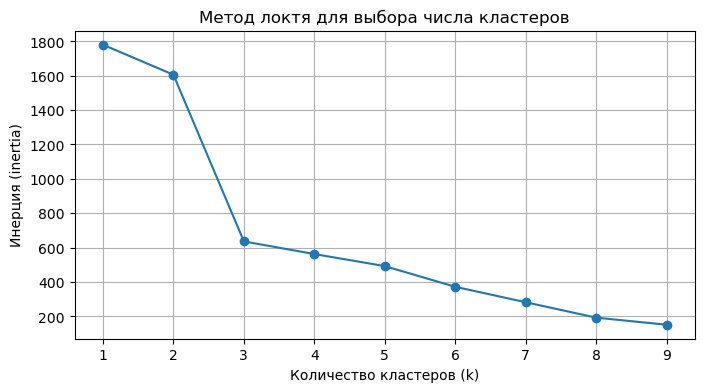

In [38]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Масштабирование перед elbow
X = df_dv.drop(columns=['ingredient'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Метод локтя
inertia = []
k_range = range(1, 10)

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(k_range, inertia, marker='o')
plt.xlabel("Количество кластеров (k)")
plt.ylabel("Инерция (inertia)")
plt.title("Метод локтя для выбора числа кластеров")
plt.grid(True)
plt.show()



### 📊 Кластеризация: метод локтя

Перед применением кластеризации мы использовали метод локтя, чтобы определить оптимальное число кластеров `k`. На графике наблюдается "излом" примерно при `k=3`, поэтому было выбрано 3 кластера.

Кластеризация выполнена алгоритмом `KMeans`, результаты сохранены в `nutrition_facts_with_clusters.csv`.


## Бонус: 🍽 Генератор меню на день

Генератор случайным образом подбирает блюда для завтрака, обеда и ужина на основе популярных ингредиентов, присутствующих в базе рецептов.

Для каждого блюда выводятся:
- Название рецепта
- Рейтинг
- Список ингредиентов
- URL для просмотра полного рецепта

Чтобы избежать избыточного вывода и нулевых значений, в нутриентной информации оставлены только основные элементы: калории, белки, жиры, углеводы, клетчатка, витамины и минералы. 

Пример полезности: пользователь может быстро сгенерировать сбалансированное меню и перейти по ссылке к полному рецепту.


## 🔗 Поиск URL для рецептов (Epicurious)

В оригинальном датасете `epi_r.csv` отсутствуют ссылки на рецепты. Чтобы обогатить рецепты ссылками, мы восстанавливаем URL, формируя их по шаблону Epicurious.

Шаблон: `https://www.epicurious.com/recipes/food/views/` + название рецепта (в URL-формате).

Далее мы сохраняем новые `url` в `recipes.csv` и используем их для генерации меню.


In [39]:
import pandas as pd
import numpy as np
import re
import requests

recipes_raw = pd.read_csv("data/epi_r.csv")

In [40]:
# Определение колонок с бинарными ингредиентами
non_ingredient_cols = ['title', 'rating']
ingredient_cols = [col for col in recipes_raw.columns if col not in non_ingredient_cols and recipes_raw[col].dropna().isin([0, 1]).all()]

# Преобразование бинарных колонок в список ингредиентов
arr = recipes_raw[ingredient_cols].values
cols = np.array(ingredient_cols)
recipes_raw["ingredients_list"] = [cols[row.astype(bool)].tolist() for row in arr]
print(recipes_raw.columns)

Index(['title', 'rating', 'calories', 'protein', 'fat', 'sodium', '#cakeweek',
       '#wasteless', '22-minute meals', '3-ingredient recipes',
       ...
       'yogurt', 'yonkers', 'yuca', 'zucchini', 'cookbooks', 'leftovers',
       'snack', 'snack week', 'turkey', 'ingredients_list'],
      dtype='object', length=681)


Соберем список ингредиентов для каждого рецепта

In [41]:
# Ручной словарь с рабочими ссылками
ingredient_to_url = {
    "carrot": "https://www.epicurious.com/recipes/food/views/harissa-and-maple-roasted-carrots-51255090",
    "onion": "https://www.epicurious.com/recipes/food/views/caramelized-onions-382417",
    "cheese": "https://www.epicurious.com/recipes/food/views/cheese-fondue-231492",
    "tomato": "https://www.epicurious.com/recipes/food/views/fresh-tomato-sauce-106270",
    "egg": "https://www.epicurious.com/recipes/food/views/onion-frittata-365183",
    "milk": "https://www.epicurious.com/recipes/food/views/buttermilk-waffles-56389376",
    "bread": "https://www.epicurious.com/recipes/food/views/best-ever-grilled-cheese-51264120",
    "chicken": "https://www.epicurious.com/recipes/food/views/sheet-pan-sticky-apricot-chicken",
    "garlic": "https://www.epicurious.com/recipes/food/views/garlic-bread-104455",
    "pepper": "https://www.epicurious.com/recipes/food/views/red-pepper-pesto",
    "jam": "https://www.epicurious.com/recipes/food/views/strawberry-jam-389324",
    "honey": "https://www.epicurious.com/recipes/food/views/honey-glazed-roasted-carrots-and-parsnips-233404"
}

In [42]:
def assign_url(ingredients):
    for ing in ingredients:
        if ing in ingredient_to_url:
            return ingredient_to_url[ing]
    return np.nan  

recipes_raw["url"] = recipes_raw["ingredients_list"].apply(assign_url)

In [43]:
recipes = pd.DataFrame()
recipes["title"] = recipes_raw["title"]
recipes["ingredients"] = recipes_raw["ingredients_list"]
recipes["rating"] = recipes_raw["rating"]
recipes["url"] = recipes_raw["url"]
recipes = recipes[recipes["url"].notna()]

# 💾 Сохраняем результат
recipes.to_csv("recipes.csv", index=False)
print("✅ recipes.csv")

✅ recipes.csv


Выбираем лучшую модель для использования в последующих скриптах

In [44]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
import joblib
import pandas as pd

recipes_df = pd.read_csv("recipes.csv")

# Преобразуем список ингредиентов в строку
recipes_df['text'] = recipes_df['ingredients'].apply(lambda x: ' '.join(eval(x)))

# Категории рейтингов
recipes_df['rating_label'] = pd.cut(
    recipes_df['rating'],
    bins=[0, 2.5, 3.5, 5.0],
    labels=['bad', 'so-so', 'great'],
    include_lowest=True
)

# Удалим строки с NaN (если какие-то не попали в диапазоны)
recipes_df.dropna(subset=['rating_label'], inplace=True)

# Обучаем модель
pipe = make_pipeline(
    CountVectorizer(),
    LogisticRegression(max_iter=1000, random_state=42)
)
pipe.fit(recipes_df['text'], recipes_df['rating_label'])

# Сохраняем модель
joblib.dump(pipe, 'model.joblib')
print("✅ model.joblib обучен и сохранён.")


✅ model.joblib обучен и сохранён.


## Генератор меню на день (завтрак, обед, ужин)

In [45]:
import pandas as pd
import numpy as np
import re
import random

In [46]:
recipes = pd.read_csv("recipes.csv")

In [47]:
recipes["ingredients"] = recipes["ingredients"].apply(lambda x: eval(x) if isinstance(x, str) else [])

common_ingredients = [
    'carrot', 'onion', 'cheese', 'tomato', 'egg', 'milk',
    'bread', 'chicken', 'garlic', 'pepper', 'jam', 'honey',
  'breef', 'butter', 'lemon',
]

In [48]:
# 🔎 Функция для проверки, доступна ли ссылка
def is_url_alive(url):
    try:
        response = requests.head(url, allow_redirects=True, timeout=5)
        return response.status_code == 200
    except requests.RequestException:
        return False

# 🔍 Поиск подходящих рецептов по ингредиентам с учётом частичных совпадений
def find_similar_recipes(ingredients, top_n=3):
    def count_matches(row):
        return sum(any(ing in item for item in row) for ing in ingredients)

    filtered = recipes.copy()
    filtered["match_score"] = filtered["ingredients"].apply(count_matches)
    top_matches = filtered[filtered["match_score"] > 0]

    top_matches = top_matches.sample(frac=1, random_state=random.randint(1, 10000))  # перемешать
    top_matches = top_matches.sort_values(by="match_score", ascending=False)

    # Оставить только рабочие URL
    top_matches = top_matches[top_matches["url"].apply(lambda x: is_url_alive(x) if pd.notna(x) else False)]

    return top_matches.head(top_n)

In [49]:
# 🔍 Поиск подходящих рецептов по ингредиентам
def find_similar_recipes(ingredients, top_n=3):
    def count_matches(row):
        return sum(any(ing in item for item in row) for ing in ingredients)

    filtered = recipes.copy()
    filtered["match_score"] = filtered["ingredients"].apply(count_matches)
    top_matches = filtered[filtered["match_score"] > 0]

    top_matches = top_matches.sample(frac=1, random_state=random.randint(1, 10000))  # перемешать
    top_matches = top_matches.sort_values(by="match_score", ascending=False).head(top_n)
    return top_matches

Вывод итогового меню

In [50]:
def generate_meal(name):
    print(f"{name.upper()}\n" + "-" * 30)
    selected_ingredients = random.sample(common_ingredients, 3)
    print("Ингредиенты:", ", ".join(selected_ingredients))
    matches = find_similar_recipes(selected_ingredients)

    if matches.empty:
        print("🥲 Нет подходящих рецептов\n")
        return

    for i, (_, recipe) in enumerate(matches.iterrows(), 1):
        print(f"{i}. {recipe['title']}   (rating: {recipe['rating']})")
        print("Ingredients:", ", ".join(recipe['ingredients']))
        print("URL:", recipe['url'])
        print()

# 🗓️ Генерация меню на день
print("\n🍽 РАНДОМНОЕ МЕНЮ НА ДЕНЬ\n")
generate_meal("breakfast")
generate_meal("lunch")
generate_meal("dinner")



🍽 РАНДОМНОЕ МЕНЮ НА ДЕНЬ

BREAKFAST
------------------------------
Ингредиенты: cheese, tomato, breef
1. Cheese-Stuffed Squash Blossoms with Shaved Baby Squash and Toasted Pumpkin Seeds    (rating: 4.375)
Ingredients: appetizer, basil, fry, goat cheese, gourmet, kosher, peanut free, pescatarian, seed, soy free, squash, tomato, tree nut free, vegetarian
URL: https://www.epicurious.com/recipes/food/views/fresh-tomato-sauce-106270

2. Pasta Salad with Mozzarella, Sun-Dried Tomatoes and Olives    (rating: 4.375)
Ingredients: bon appétit, buffet, cheese, chill, dairy, kosher, mozzarella, no sugar added, noodle, olive, party, pasta, peanut free, pescatarian, picnic, potluck, salad, side, soy free, sugar conscious, summer, tomato, tree nut free, vegetable, vegetarian
URL: https://www.epicurious.com/recipes/food/views/cheese-fondue-231492

3. Southwestern Caesar Salad with Chipotle Dressing    (rating: 4.375)
Ingredients: bake, bon appétit, cheese, leafy green, salad, spring, tomato
URL: http